# Statistical Analysis

#### Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import json
import glob
import os
import seaborn as sns
import itertools
import re
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Tuple, Sequence, Mapping
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.patches import Patch
from matplotlib.colors import TwoSlopeNorm
import textwrap

In [4]:
def set_project_root_cwd(root_dir_name: str, max_depth: int = 10) -> Optional[Path]:
    """
    Sets CWD to the project root. Handles 'src' layouts by skipping 
    inner package directories with the same name.
    """
    try:
        current_path = Path.cwd()
        original_cwd = current_path
        
        for _ in range(max_depth):
            if current_path.name == root_dir_name:
                if current_path.parent.name == 'src':
                    current_path = current_path.parent
                    continue
                
                os.chdir(current_path)
                print(f"CWD set to project root: {current_path}")
                return current_path
            
            if current_path.parent == current_path:
                break
            
            current_path = current_path.parent
            
        raise FileNotFoundError(f"Project root '{root_dir_name}' not found within {max_depth} levels of {original_cwd}")
        
    except Exception as e:
        print(f"Error setting CWD: {e}")
        return None

In [5]:
set_project_root_cwd('rag_uncertainty')

CWD set to project root: /vol/tensusers8/fgerding/rag_uncertainty


PosixPath('/vol/tensusers8/fgerding/rag_uncertainty')

In [6]:
# paths = sorted(glob.glob("./results/results_rank*.json"))
# all_records = []

# for path in paths:
#     with open(path, "r", encoding="utf-8") as f:
#         all_records.extend(json.load(f))

# merged_path = "results/results.json"
# with open(merged_path, "w", encoding="utf-8") as f:
#     json.dump(all_records, f, indent=2, ensure_ascii=False)

# print(f"Merged {len(paths)} files into {merged_path} with {len(all_records)} records")

In [7]:
merged_path = "results/results.json"

In [8]:
with open(merged_path, "r", encoding="utf-8") as f:
    data = json.load(f)

In [9]:
unique_questions = {x['question'] for x in data}
print(f"Total number of processed unique questions: {len(unique_questions)}")
# print(f'Questions:')
# print('-'*50)
# print('\n'.join(unique_questions))

Total number of processed unique questions: 150


In [10]:
raw_questions_path = Path("./src/rag_uncertainty/questions.json")
with open(raw_questions_path, "r") as f:
    raw_questions = json.load(f)
flattened_list = [item for sublist in list(raw_questions.values()) for item in sublist]
print(f'Total questions: {len(flattened_list)}')

Total questions: 250


### Structure

In [13]:
@dataclass(frozen=True)
class RafeDetail:
    claim: str
    label: str
    evidence: List[str] = field(default_factory=list)
    uncertainty_score: Optional[float] = None

    @staticmethod
    def from_dict(d: Dict[str, Any]) -> "RafeDetail":
        return RafeDetail(
            claim=d.get("claim", ""),
            label=d.get("label", ""),
            evidence=list(d.get("evidence", []) or []),
            uncertainty_score=d.get("uncertainty_score", None),
        )


@dataclass
class GenerationSample:
    answer: str
    atomic_facts: List[str]
    rafe_details: List[RafeDetail]

    # per-sample metrics
    semantic_entropy_per_gen: Optional[float]
    rafe_gen_score: Optional[float]
    rafe_gen_supported: Optional[int]
    rafe_gen_not_supported: Optional[int]
    rafe_gen_irrelevant: Optional[int]
    rafe_gen_total_claims: Optional[int]

    # per-sample CEM artifacts
    cem_matrix: Dict[str, Dict[str, int]]
    cem_evidence_scores: Dict[str, float]

    @staticmethod
    def from_record(rec: Dict[str, Any]) -> "GenerationSample":
        return GenerationSample(
            answer=rec["answer"],
            atomic_facts=list(rec.get("atomic_facts", []) or []),
            rafe_details=[RafeDetail.from_dict(x) for x in (rec.get("rafe_details", []) or [])],
            semantic_entropy_per_gen=rec.get("semantic_entropy_per_gen", None),
            rafe_gen_score=rec.get("rafe_gen_score", None),
            rafe_gen_supported=rec.get("rafe_gen_supported", None),
            rafe_gen_not_supported=rec.get("rafe_gen_not_supported", None),
            rafe_gen_irrelevant=rec.get("rafe_gen_irrelevant", None),
            rafe_gen_total_claims=rec.get("rafe_gen_total_claims", None),
            cem_matrix=dict(rec.get("cem_matrix", {}) or {}),
            cem_evidence_scores=dict(rec.get("cem_evidence_scores", {}) or {}),
        )

    def cem_df(self) -> pd.DataFrame:
        """
        Convert cem_matrix (doc -> {claim -> 0/1}) into a claim x doc DataFrame.
        """
        cem = self.cem_matrix or {}
        if not cem:
            return pd.DataFrame()

        # Stable doc ordering: doc_0, doc_1, ...
        def doc_key(d: str) -> Tuple[int, str]:
            m = re.match(r"doc_(\d+)$", d)
            return (int(m.group(1)) if m else 10**9, d)

        docs = sorted(cem.keys(), key=doc_key)

        # Prefer claim order from first doc; then append any unseen claims from other docs
        claims: List[str] = []
        seen = set()
        for d in docs:
            for c in cem[d].keys():
                if c not in seen:
                    seen.add(c)
                    claims.append(c)

        mat = np.zeros((len(claims), len(docs)), dtype=int)
        for j, d in enumerate(docs):
            cd = cem[d]
            for i, c in enumerate(claims):
                if c in cd:
                    mat[i, j] = int(cd[c])

        df = pd.DataFrame(mat, index=claims, columns=docs)
        return df

    def cem_claim_uncertainty(self) -> pd.Series:
        """
        Claim uncertainty U(ci) = 1 - mean_j Mij
        """
        df = self.cem_df()
        if df.empty:
            return pd.Series(dtype=float)
        return 1.0 - df.mean(axis=1)

    def cem_response_uncertainty(self) -> float:
        """
        Aggregate a single response's CEM uncertainty as mean over claims.
        """
        u = self.cem_claim_uncertainty()
        return float(u.mean()) if len(u) else float("nan")


@dataclass
class QuestionRecord:
    category: str
    question: str

    # question-level metrics (computed over the set of samples and duplicated per record in the flat file)
    semantic_entropy_global: float
    semantic_entropy_truth_value: float
    sum_eigen: float
    sum_eigen_truth_value: float
    rafe_overall_score: float
    rafe_overall_precision: float

    samples: List[GenerationSample] = field(default_factory=list)

    def validate(self, expected_n: int = 5) -> Dict[str, Any]:
        answers = [s.answer for s in self.samples]
        unique_answers = len(set(answers))
        return {
            "n_samples": len(self.samples),
            "unique_answers": unique_answers,
            "has_expected_n": len(self.samples) == expected_n,
            "all_answers_unique": unique_answers == len(self.samples),
        }

    def cem_uncertainty_mean_over_samples(self) -> float:
        vals = [s.cem_response_uncertainty() for s in self.samples]
        vals = [v for v in vals if not np.isnan(v)]
        return float(np.mean(vals)) if vals else float("nan")


@dataclass
class ResultsDataset:
    questions: List[QuestionRecord]

    @staticmethod
    def from_flat_records(records: List[Dict[str, Any]]) -> "ResultsDataset":
        # group by (category, question)
        groups: Dict[Tuple[str, str], List[Dict[str, Any]]] = {}
        for r in records:
            key = (r["category"], r["question"])
            groups.setdefault(key, []).append(r)

        qrecs: List[QuestionRecord] = []
        for (cat, q), recs in groups.items():
            # take question-level metrics from the first record, assume same across group
            r0 = recs[0]

            qr = QuestionRecord(
                category=cat,
                question=q,
                semantic_entropy_global=float(r0.get("semantic_entropy_global", np.nan)),
                semantic_entropy_truth_value=float(r0.get("semantic_entropy_truth_value", np.nan)),
                sum_eigen=float(r0.get("sum_eigen", np.nan)),
                sum_eigen_truth_value=float(r0.get("sum_eigen_truth_value", np.nan)),
                rafe_overall_score=float(r0.get("rafe_overall_score", np.nan)),
                rafe_overall_precision=float(r0.get("rafe_overall_precision", np.nan)),
                samples=[GenerationSample.from_record(r) for r in recs],
            )

            qrecs.append(qr)

        # stable ordering
        qrecs.sort(key=lambda x: (x.category, x.question))
        return ResultsDataset(questions=qrecs)

    def question_level_frame(self) -> pd.DataFrame:
        """
        One row per question with question-level UEs and aggregated CEM.
        Interpreting "uncertainty":
          - semantic entropy uncertainty: use semantic_entropy_truth_value (it is -semantic_entropy_global in your file)
          - sum eigen uncertainty: use sum_eigen
          - CEM uncertainty: mean over samples of mean over claims of (1 - support redundancy)
        """
        rows = []
        for q in self.questions:
            rows.append({
                "category": q.category,
                "question": q.question,
                "rafe_overall_score": q.rafe_overall_score,
                "rafe_overall_precision": q.rafe_overall_precision,
                "semantic_entropy_uncertainty": q.semantic_entropy_truth_value,
                "sum_eigen_uncertainty": q.sum_eigen,
                "cem_uncertainty": q.cem_uncertainty_mean_over_samples(),
                "n_samples": len(q.samples),
                "n_unique_answers": len({s.answer for s in q.samples}),
            })
        return pd.DataFrame(rows)

### Load json into ResultsDataset structure

In [14]:
ds = ResultsDataset.from_flat_records(data)

In [15]:
qdf = ds.question_level_frame()
display(qdf[["category", "question", "n_samples", "n_unique_answers"]])

# Validation summary
val = []
for q in ds.questions:
    v = q.validate(expected_n=5)
    val.append({"category": q.category, "question": q.question, **v})
val_df = pd.DataFrame(val)
display(val_df)

,category,question,n_samples,n_unique_answers
0,20th Century Events,Can you describe what happened in the Apollo 1...,5,5
1,20th Century Events,Can you tell me about the assassination of Mar...,5,5
2,20th Century Events,What took place during the Berlin Wall constru...,5,5
3,20th Century Events,What unfolded during the Oklahoma City bombing...,5,5
4,20th Century Events,What were the events that took place during th...,5,5
...,...,...,...,...
145,Marketing,"What are the specifics of IBM’s ""Smarter Plane...",5,5
146,Marketing,"What is the approach behind Google’s ""Year in ...",5,5
147,Mathematics,Who is David Hilbert?,5,5
148,Mathematics,Who is Yitang Zhang?,5,5


,category,question,n_samples,unique_answers,has_expected_n,all_answers_unique
0,20th Century Events,Can you describe what happened in the Apollo 1...,5,5,True,True
1,20th Century Events,Can you tell me about the assassination of Mar...,5,5,True,True
2,20th Century Events,What took place during the Berlin Wall constru...,5,5,True,True
3,20th Century Events,What unfolded during the Oklahoma City bombing...,5,5,True,True
4,20th Century Events,What were the events that took place during th...,5,5,True,True
...,...,...,...,...,...,...
145,Marketing,"What are the specifics of IBM’s ""Smarter Plane...",5,5,True,True
146,Marketing,"What is the approach behind Google’s ""Year in ...",5,5,True,True
147,Mathematics,Who is David Hilbert?,5,5,True,True
148,Mathematics,Who is Yitang Zhang?,5,5,True,True


In [16]:
def corr_pearson(x: pd.Series, y: pd.Series) -> float:
    ok = x.notna() & y.notna()
    if ok.sum() < 2:
        return float("nan")
    return float(x[ok].corr(y[ok], method="pearson"))

def corr_spearman(x: pd.Series, y: pd.Series) -> float:
    ok = x.notna() & y.notna()
    if ok.sum() < 2:
        return float("nan")
    return float(x[ok].corr(y[ok], method="spearman"))

def ue_vs_rafe_table(qdf: pd.DataFrame, target_col: str = "rafe_overall_score",
                     ue_cols: List[str] = None) -> pd.DataFrame:
    if ue_cols is None:
        ue_cols = ["semantic_entropy_uncertainty", "sum_eigen_uncertainty", "cem_uncertainty"]
    rows = []
    for ue in ue_cols:
        rows.append({
            "UE": ue,
            "Pearson_r": corr_pearson(qdf[ue], qdf[target_col]),
            "Spearman_rho": corr_spearman(qdf[ue], qdf[target_col]),
        })
    return pd.DataFrame(rows)

corr_table = ue_vs_rafe_table(qdf, target_col="rafe_overall_score")
print("Table: UE vs. RAFE:")
display(corr_table)

Table: UE vs. RAFE:


,UE,Pearson_r,Spearman_rho
0,semantic_entropy_uncertainty,0.037100,0.078201
1,sum_eigen_uncertainty,-0.058332,-0.195038
2,cem_uncertainty,-0.124164,-0.419168


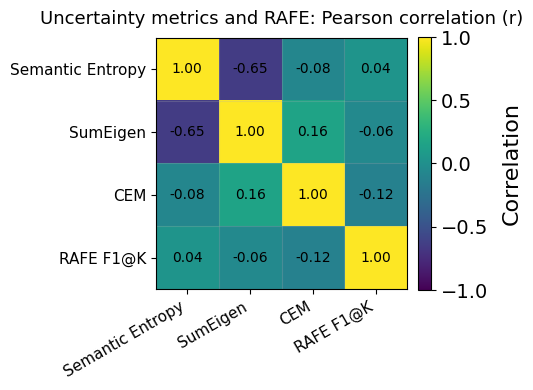

In [49]:
def plot_corr_heatmap_publication(
    df: pd.DataFrame,
    cols: list[str],
    *,
    method: str = "spearman",
    title: str | None = None,
    rename: dict[str, str] | None = None,
    figsize: tuple[float, float] | None = None,
    annot: bool = True,
    annot_fontsize: int = 10,
    show_colorbar: bool = True,
    save_to: str | None = None,
):
    # Correlation matrix
    mat = df[cols].corr(method=method)

    # Friendly names
    if rename is None:
        rename = {
            "semantic_entropy_uncertainty": "Semantic Entropy",
            "sum_eigen_uncertainty": "SumEigen",
            "cem_uncertainty": "CEM",
            "rafe_overall_score": "RAFE F1@K",
            "rafe_overall_precision": "RAFE Precision",
        }

    mat = mat.rename(index=rename, columns=rename)

    # Default title
    if title is None:
        title = f"Correlation matrix (Spearman ρ)" if method == "spearman" else f"Correlation matrix (Pearson r)"

    n = mat.shape[0]
    if figsize is None:
        figsize = (1.2 + 1.1 * n, 1.0 + 1.0 * n)

    arr = mat.to_numpy(dtype=float)

    fig, ax = plt.subplots(figsize=figsize)

    # Center at 0, symmetric colors
    norm = TwoSlopeNorm(vmin=-1.0, vcenter=0.0, vmax=1.0)
    im = ax.imshow(arr, norm=norm, aspect="equal", interpolation="nearest")

    # Ticks/labels
    ax.set_xticks(range(n))
    ax.set_yticks(range(n))
    ax.set_xticklabels(mat.columns, rotation=30, ha="right", fontsize=11)
    ax.set_yticklabels(mat.index, fontsize=11)

    # Gridlines between cells
    ax.set_xticks(np.arange(-.5, n, 1), minor=True)
    ax.set_yticks(np.arange(-.5, n, 1), minor=True)
    ax.grid(which="minor", linewidth=0.8, alpha=0.25)
    ax.tick_params(which="minor", bottom=False, left=False)

    ax.set_title(title, fontsize=13, pad=10)

    # Annotate values
    if annot:
        for i in range(n):
            for j in range(n):
                v = arr[i, j]
                if np.isfinite(v):
                    ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=annot_fontsize)

    # Colorbar
    if show_colorbar:
        cbar = fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label("Correlation", rotation=90, labelpad=10)

    plt.tight_layout()
    if save_to:
        plt.savefig(save_to)
    else: 
        plt.show()

# Include RAFE in the same plot
cols = [
    "semantic_entropy_uncertainty",
    "sum_eigen_uncertainty",
    "cem_uncertainty",
    "rafe_overall_score",
]

plot_corr_heatmap_publication(
    qdf,
    cols=cols,
    method="pearson",
    title="Uncertainty metrics and RAFE: Pearson correlation (r)",
    save_to="figures/correlations_hm_pearson.pdf"
)

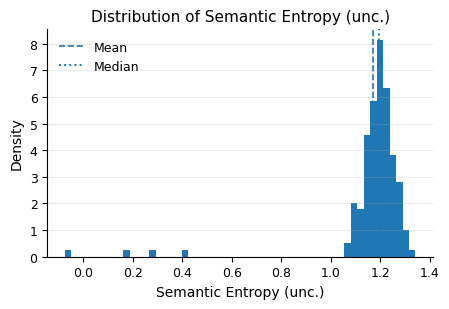

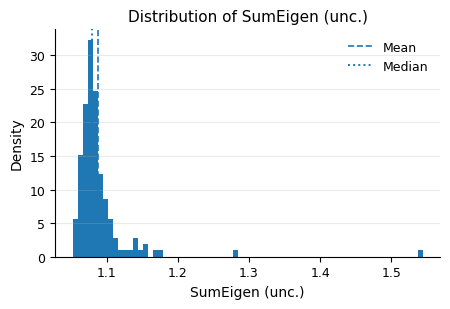

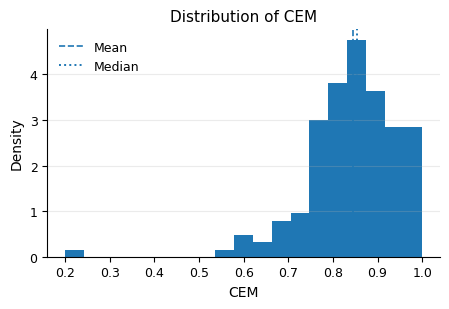

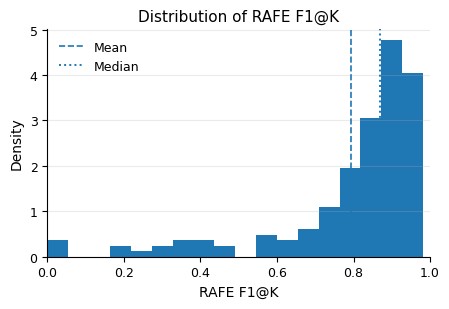

,Metric,n,mean,std,min,p25,median,p75,max
0,semantic_entropy_uncertainty,150,1.169045,0.171607,-0.074334,1.157091,1.194249,1.226801,1.341854
1,sum_eigen_uncertainty,150,1.088249,0.046122,1.052122,1.070554,1.079487,1.089369,1.543909
2,cem_uncertainty,150,0.844022,0.107812,0.200000,0.793925,0.854277,0.910757,1.000000
3,rafe_overall_score,150,0.793841,0.210121,0.000000,0.773199,0.869206,0.923021,0.981842


In [18]:
def plot_metric_histograms(
    df: pd.DataFrame,
    cols: Sequence[str],
    *,
    rename: Optional[Mapping[str, str]] = None,
    bins: Any = "fd",  # int | "fd" | "auto"
    density: bool = True,
    dropna: bool = True,
    xlims: Optional[Mapping[str, tuple[float, float]]] = None,
    figsize: tuple[float, float] = (4.6, 3.2),
    dpi: int = 300,
    save_dir: Optional[str | Path] = None,
    file_prefix: str = "hist",
    file_ext: str = "pdf",
    show: bool = True,
) -> pd.DataFrame:
    """
    Plots one publication-style histogram per metric (one figure per column).
    Optionally saves figures for paper appendix.

    Returns a summary table (n, mean, std, quantiles) for the plotted metrics.
    """
    if rename is None:
        rename = {
            "semantic_entropy_uncertainty": "Semantic Entropy (unc.)",
            "sum_eigen_uncertainty": "SumEigen (unc.)",
            "cem_uncertainty": "CEM",
            "rafe_overall_score": "RAFE F1@K",
            "rafe_overall_precision": "RAFE Precision",
        }

    if save_dir is not None:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)

    rows = []

    for col in cols:
        s = df[col]
        if dropna:
            s = s.dropna()
        values = s.to_numpy(dtype=float)

        if values.size == 0:
            rows.append({"metric": col, "n": 0})
            continue

        # Summary stats for appendix text/table
        q25, q50, q75 = np.quantile(values, [0.25, 0.50, 0.75])
        rows.append({
            "metric": col,
            "n": int(values.size),
            "mean": float(np.mean(values)),
            "std": float(np.std(values, ddof=1)) if values.size > 1 else float("nan"),
            "min": float(np.min(values)),
            "p25": float(q25),
            "median": float(q50),
            "p75": float(q75),
            "max": float(np.max(values)),
        })

        # Bin selection
        if isinstance(bins, str):
            bin_edges = np.histogram_bin_edges(values, bins=bins)
        else:
            bin_edges = bins

        fig, ax = plt.subplots(figsize=figsize)

        ax.hist(values, bins=bin_edges, density=density)

        # Mean / median markers (no explicit colors)
        ax.axvline(np.mean(values), linestyle="--", linewidth=1.2, label="Mean")
        ax.axvline(np.median(values), linestyle=":", linewidth=1.4, label="Median")

        label = rename.get(col, col)
        ax.set_title(f"Distribution of {label}", fontsize=11)
        ax.set_xlabel(label, fontsize=10)
        ax.set_ylabel("Density" if density else "Count", fontsize=10)

        # Optional per-metric x-limits (useful for bounded scores)
        if xlims is not None and col in xlims:
            ax.set_xlim(*xlims[col])

        # Clean appendix style
        ax.grid(True, axis="y", alpha=0.25)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.tick_params(labelsize=9)
        ax.legend(frameon=False, fontsize=9)

        plt.tight_layout()

        if save_dir is not None:
            safe_name = re.sub(r"[^a-zA-Z0-9_]+", "_", col)
            out_path = save_dir / f"{file_prefix}_{safe_name}.{file_ext}"
            fig.savefig(out_path, bbox_inches="tight")

        if show:
            plt.show()
        else:
            plt.close(fig)

    return pd.DataFrame(rows).rename(columns={"metric": "Metric"})


# Example usage for appendix:
cols = [
    "semantic_entropy_uncertainty",
    "sum_eigen_uncertainty",
    "cem_uncertainty",
    "rafe_overall_score",
]

# Optional: enforce nice x-limits for bounded metrics
xlims = {
    "rafe_overall_score": (0.0, 1.0),
    "rafe_overall_precision": (0.0, 1.0),
}

summary = plot_metric_histograms(
    qdf,
    cols,
    bins="fd",
    density=True,
    xlims=xlims,
    save_dir="figures/appendix_hists",
    file_prefix="appendix_hist",
    file_ext="pdf",
)
display(summary)

# CEM Matrix

In [ ]:
def plot_cem(
    sample: GenerationSample,
    title: str = "RAFE + CEM",
    claim_wrap_width: int = 60,
    max_claims: int | None = None,                 # applied after selection/order
    selected_claims: list[str] | None = None,      # if set: use these (in order), even if not in CEM
    show_rafe_column: bool = True,
    cem_text_mode: str = "supported_only",         # "supported_only" | "both" | "none"
    cem_labels: tuple[str, str] = ("✗", "✓"),      # (not_supported, supported)
    add_ellipsis_row: bool = True,                 # if selected_claims: always append "…" row
    sort_rows: bool = True,                        # used only when selected_claims is None
    figsize: tuple[float, float] | None = None,
    save_to: str | None = None,
    base_fontsize: int = 12,
):
    mpl.rcParams.update({
        "font.size": base_fontsize,
        "axes.titlesize": base_fontsize + 2,
        "axes.labelsize": base_fontsize,
        "xtick.labelsize": base_fontsize - 2,
        "ytick.labelsize": base_fontsize - 2,
        "legend.fontsize": base_fontsize - 1,
        "pdf.fonttype": 42,
        "ps.fonttype": 42,
    })

    def _wrap(s: str, width: int) -> str:
        return "\n".join(textwrap.wrap(s, width=width))

    def _clean(s: str) -> str:
        return re.sub(r"\s+", " ", (s or "").strip())

    df = sample.cem_df()
    if df.empty:
        print("Empty CEM matrix.")
        return

    # RAFE claim -> label
    rafe_label_map = {_clean(rd.claim): rd.label for rd in (sample.rafe_details or [])}

    # Build df_plot
    if selected_claims is not None:
        cols = list(df.columns)
        clean_to_idx = {_clean(c): c for c in df.index}

        rows = []
        row_names = []
        for claim in selected_claims:
            row_names.append(claim)

            s = None
            if claim in df.index:
                s = df.loc[claim]
            else:
                cc = _clean(claim)
                if cc in clean_to_idx:
                    s = df.loc[clean_to_idx[cc]]

            if s is None:
                rows.append([np.nan] * len(cols))   # claim not in CEM matrix (eg IRRELEVANT)
            else:
                rows.append([float(x) for x in s.to_list()])

        df_plot = pd.DataFrame(rows, index=row_names, columns=cols)

        # Always append an ellipsis row for manual selections (unless already present)
        if add_ellipsis_row and (len(df_plot.index) == 0 or str(df_plot.index[-1]) != "…"):
            df_plot.loc["…"] = [np.nan] * len(cols)

    else:
        # Default: order by uncertainty (and optionally group by RAFE label)
        claim_u = 1.0 - df.mean(axis=1)
        df_plot = df.copy()

        if sort_rows and show_rafe_column:
            order_rank = {"NOT_SUPPORTED": 0, "IRRELEVANT": 1, "SUPPORTED": 2}
            keys = []
            for c in df_plot.index:
                lab = rafe_label_map.get(_clean(c), "NA")
                keys.append((order_rank.get(lab, 3), -float(claim_u.loc[c]), c))
            df_plot = df_plot.loc[[k[2] for k in sorted(keys)]]
        else:
            df_plot = df_plot.loc[claim_u.sort_values(ascending=False).index]

        # Apply truncation if requested
        if max_claims is not None and len(df_plot) > max_claims:
            df_plot = df_plot.head(max_claims)
            if add_ellipsis_row and (len(df_plot.index) == 0 or str(df_plot.index[-1]) != "…"):
                df_plot = pd.concat(
                    [df_plot, pd.DataFrame([[np.nan] * df_plot.shape[1]], index=["…"], columns=df_plot.columns)]
                )

    # Apply max_claims also for manual selection (if user still wants it)
    if selected_claims is not None and max_claims is not None and len(df_plot) > max_claims:
        df_plot = df_plot.head(max_claims)
        if add_ellipsis_row and (len(df_plot.index) == 0 or str(df_plot.index[-1]) != "…"):
            df_plot.loc["…"] = [np.nan] * df_plot.shape[1]

    cem_ns, cem_s = cem_labels
    rafe_text_map = {
        "SUPPORTED": cem_s,
        "NOT_SUPPORTED": cem_ns,
        "IRRELEVANT": "–",
        "NA": "",
    }

    # Build matrix (prepend RAFE column if desired)
    if show_rafe_column:
        rafe_vals = []
        rafe_text = []
        for claim in df_plot.index:
            if claim == "…":
                rafe_vals.append(np.nan)
                rafe_text.append("…")
                continue

            lab = rafe_label_map.get(_clean(str(claim)), "NA")
            rafe_text.append(rafe_text_map.get(lab, ""))

            if lab == "SUPPORTED":
                rafe_vals.append(1.0)
            elif lab == "NOT_SUPPORTED":
                rafe_vals.append(0.0)
            elif lab == "IRRELEVANT":
                rafe_vals.append(2.0)
            else:
                rafe_vals.append(np.nan)

        mat = np.concatenate(
            [np.array(rafe_vals, dtype=float).reshape(-1, 1), df_plot.to_numpy(dtype=float)],
            axis=1
        )
        xticklabels = ["RAFE"] + list(df_plot.columns)
    else:
        rafe_text = []
        mat = df_plot.to_numpy(dtype=float)
        xticklabels = list(df_plot.columns)

    n_rows, n_cols = mat.shape

    # Discrete colormap + explicit NaN color
    cmap = ListedColormap(["#f2f2f2", "#2b8cbe", "#fdae6b"])  # 0,1,2
    cmap.set_bad("#ffffff")
    norm = BoundaryNorm([-0.5, 0.5, 1.5, 2.5], cmap.N)

    if figsize is None:
        figsize = (15.0, 5 + 0.5 * n_rows)

    fig, ax = plt.subplots(figsize=figsize, dpi=300)
    ax.imshow(mat, aspect="auto", cmap=cmap, norm=norm, interpolation="nearest")

    # Gridlines
    ax.set_xticks(np.arange(-0.5, n_cols, 1), minor=True)
    ax.set_yticks(np.arange(-0.5, n_rows, 1), minor=True)
    ax.grid(which="minor", linewidth=0.6, alpha=0.22)
    ax.tick_params(which="minor", bottom=False, left=False)

    # Axis labels
    ax.set_xticks(range(n_cols))
    ax.set_yticks(range(n_rows))
    ax.set_xticklabels(xticklabels, rotation=0, ha="center")
    if show_rafe_column:
        ax.get_xticklabels()[0].set_fontweight("bold")

    ax.set_yticklabels([_wrap(str(c), claim_wrap_width) for c in df_plot.index])

    ax.set_title(title)
    ax.set_xlabel("Context chunk")
    ax.set_ylabel("Claim")

    # Divider between RAFE and doc chunks
    if show_rafe_column:
        ax.axvline(0.5, color="black", linewidth=2.0)

    # Cell text
    start_col = 1 if show_rafe_column else 0
    for i in range(n_rows):
        # Ellipsis row: no content
        if str(df_plot.index[i]) == "…":
            continue

        # RAFE cell
        if show_rafe_column:
            ax.text(0, i, rafe_text[i], ha="center", va="center", fontsize=base_fontsize)

        # CEM cells
        for j in range(start_col, n_cols):
            v = mat[i, j]
            if not np.isfinite(v):
                continue
            v = int(v)

            if cem_text_mode == "none":
                continue
            if cem_text_mode == "supported_only":
                if v == 1:
                    ax.text(j, i, cem_s, ha="center", va="center", fontsize=base_fontsize)
            else:  # "both"
                ax.text(j, i, cem_s if v == 1 else cem_ns, ha="center", va="center", fontsize=base_fontsize)

    # Legend
    legend_items = [
        Patch(facecolor=cmap(1), edgecolor="k", label=f"{cem_s} supported"),
        Patch(facecolor=cmap(0), edgecolor="k", label=f"{cem_ns} not supported"),
    ]
    if show_rafe_column:
        legend_items.append(Patch(facecolor=cmap(2), edgecolor="k", label="- irrelevant"))
    ax.legend(handles=legend_items, loc="upper left", bbox_to_anchor=(1.01, 1.0), borderaxespad=0.)

    plt.tight_layout()
    if save_to:
        plt.savefig(save_to, format="pdf", bbox_inches="tight", pad_inches=0.02)
    plt.show()


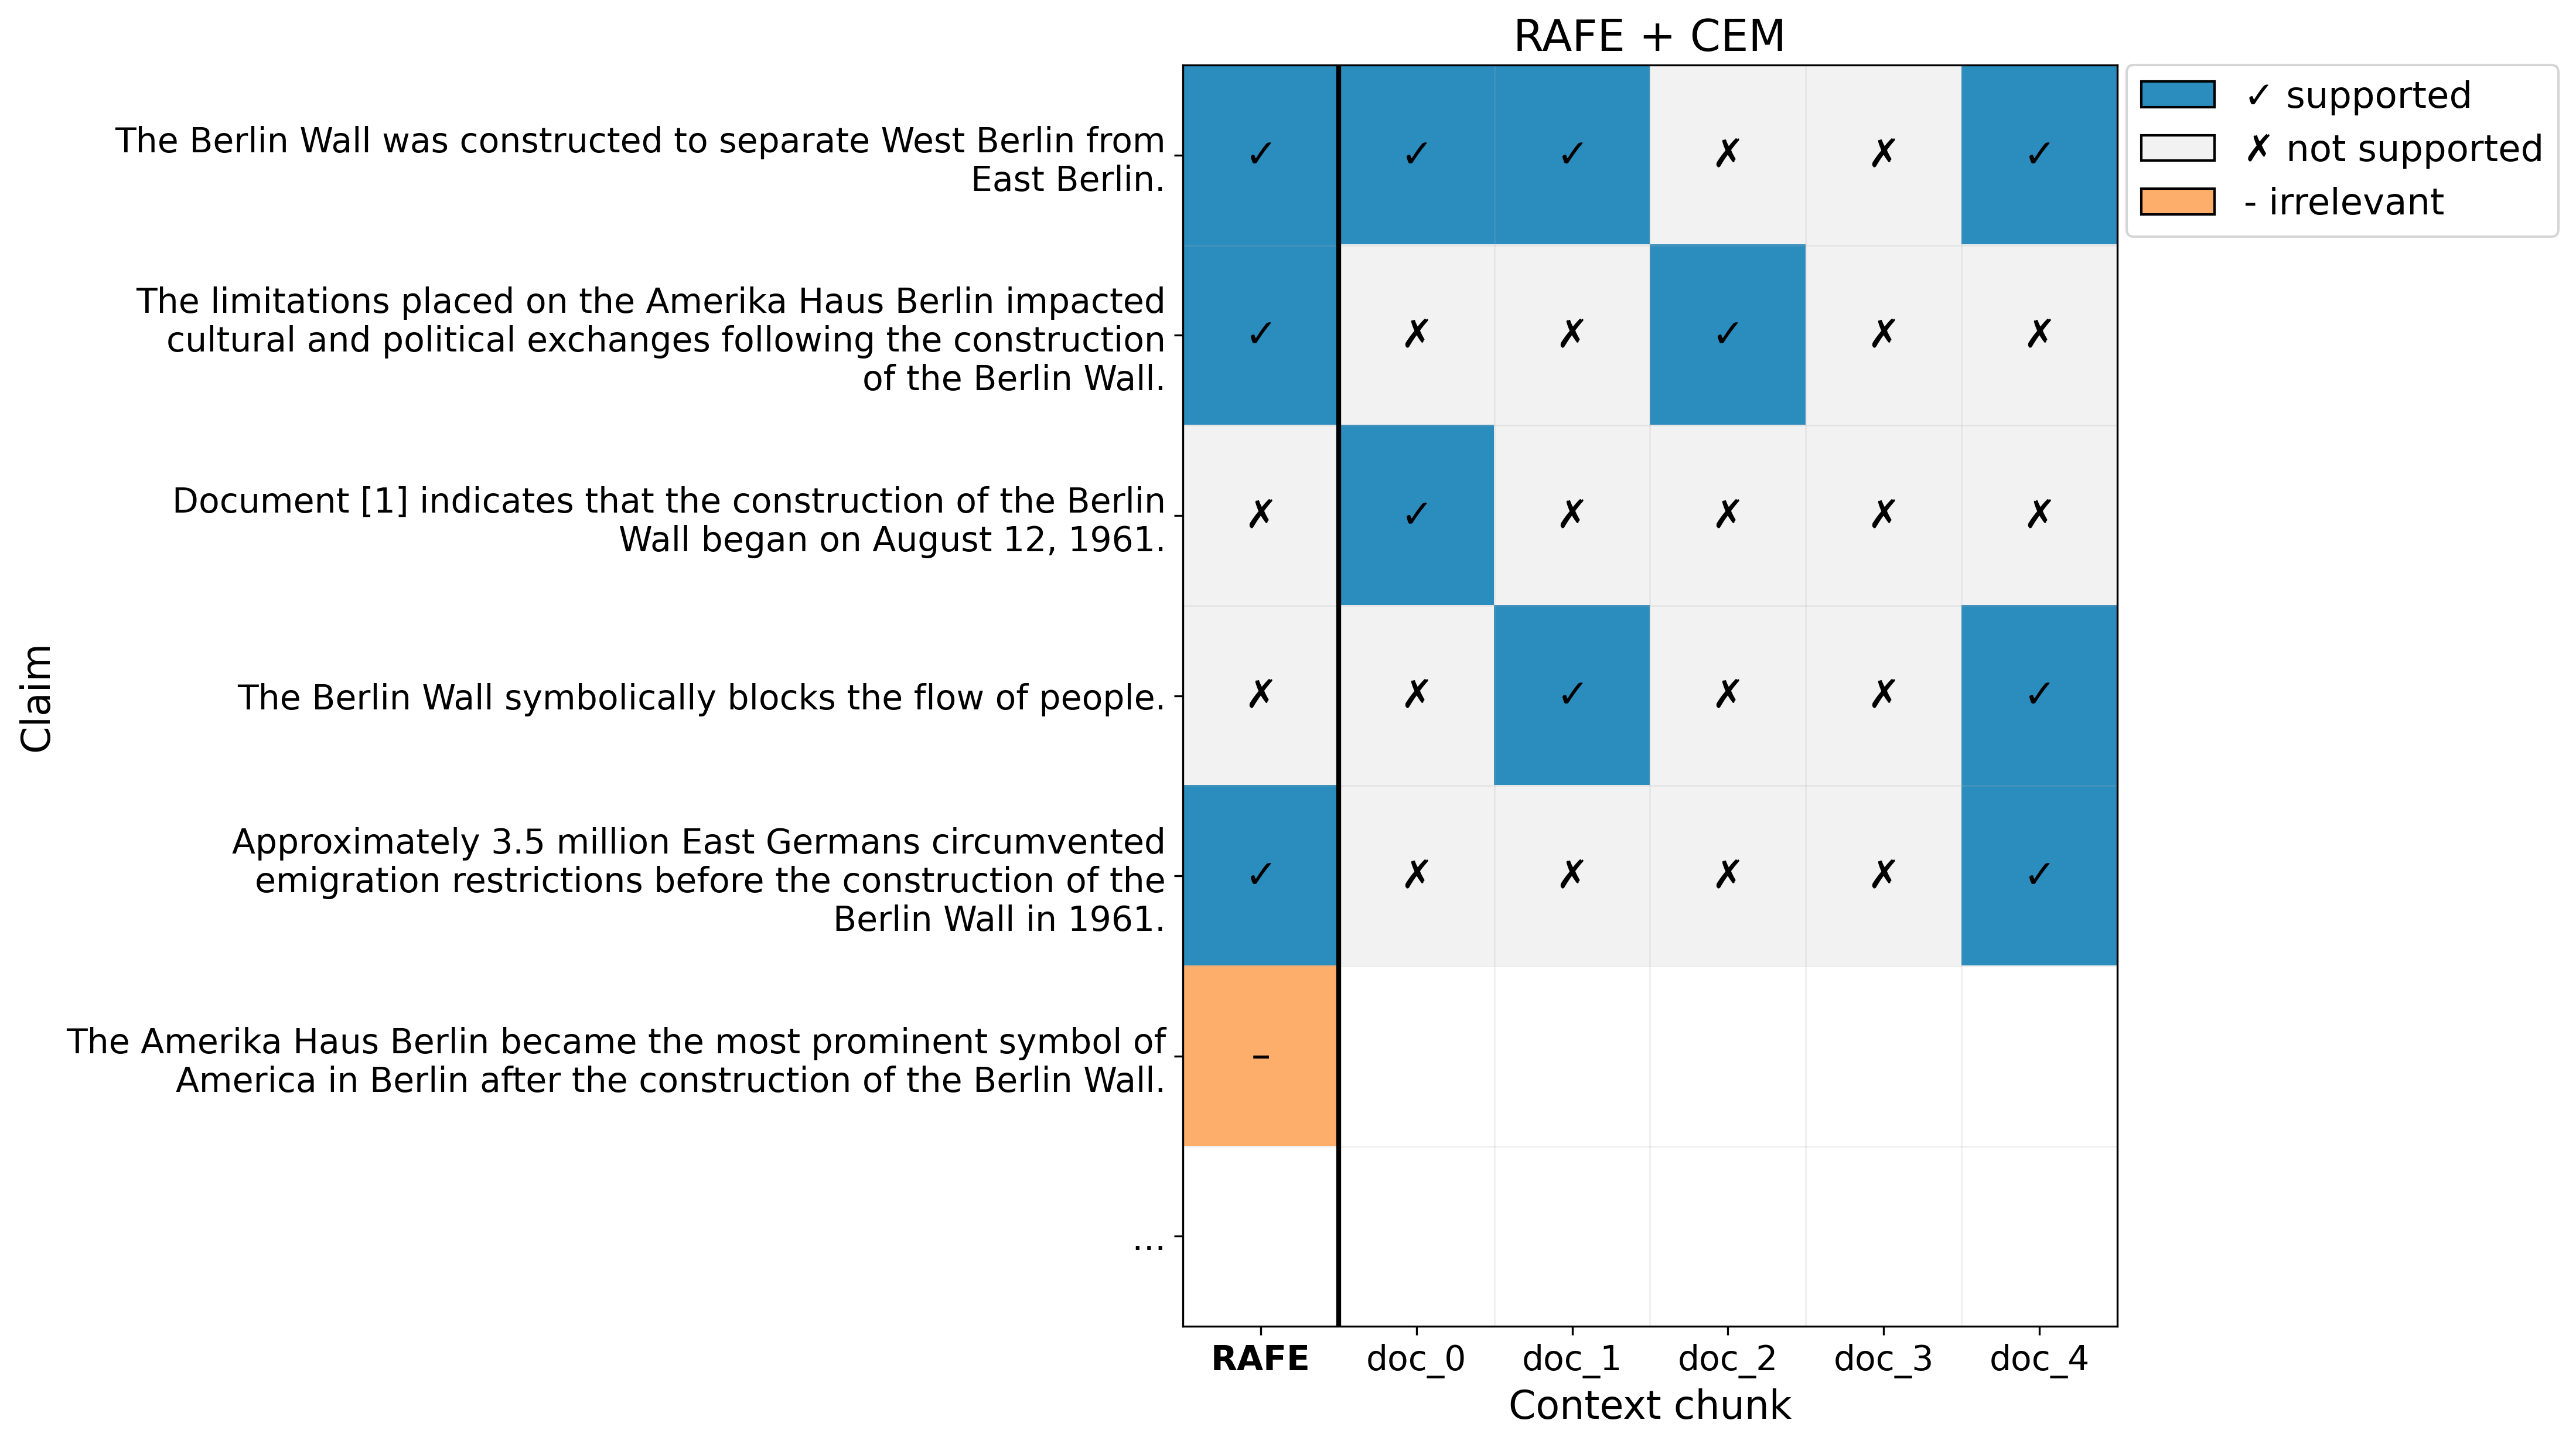

In [44]:
# subset of claims selected to illustrate the method
claims = [
    "The Berlin Wall was constructed to separate West Berlin from East Berlin.",
    "The limitations placed on the Amerika Haus Berlin impacted cultural and political exchanges following the construction of the Berlin Wall.",
    "Document [1] indicates that the construction of the Berlin Wall began on August 12, 1961.",
    "The Berlin Wall symbolically blocks the flow of people.",
    "Approximately 3.5 million East Germans circumvented emigration restrictions before the construction of the Berlin Wall in 1961.",
    "The Amerika Haus Berlin became the most prominent symbol of America in Berlin after the construction of the Berlin Wall.",  # IRRELEVANT
]

# manually selected question and answer pair to illustrate the method
question_nr = 2
answer_nr = 0
q0 = ds.questions[question_nr]
s0 = q0.samples[answer_nr]

plot_cem(
    s0,
    selected_claims=claims,
    cem_text_mode="both",
    save_to='figures/CEM_matrix_berlin_wall.pdf',
    base_fontsize=16,
)